In [19]:
# Necessary Imports

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, learning_curve
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import joblib



Data Analysis

In [20]:
data = pd.read_csv('model data/model_data.csv')
data.head()

# Success column: 0 - Unsuccessful, 1 - Successful

,Mission Name,Year,Objective,Outcome,Reason,Success
0,Challenger Shuttle Disaster,1986.0,10th flight of Space Shuttle Challenger.,Failure. Exploded 73 seconds after liftoff.,Faulty O-ring seal in its right solid rocket b...,0.0
1,Mars Climate Orbiter,1998.0,Study the Martian climate.,Failure. Burned up in the Martian atmosphere.,A metric-imperial unit mismatch in software co...,0.0
2,Columbia Shuttle Disaster,2003.0,28th flight of Space Shuttle Columbia.,Failure. Disintegrated upon re-entry.,Damage to thermal protection system caused by ...,0.0
3,Beagle 2,2003.0,Search for life on Mars.,Failure. Lost upon landing.,"One of the solar panels failed to deploy, bloc...",0.0
4,Orion 3,1995.0,Communication satellite launch.,Failure. Did not reach intended orbit.,The third stage of the rocket failed to ignite.,0.0


In [21]:
# Size of dataset

dataset_size1 = len(data)
print(dataset_size1) # number of space missions

52


Data Cleaning

In [22]:
# convert the data to DataFrame
data = pd.DataFrame(data, columns=["Mission Name", "Year", "Objective", "Outcome", "Reason", "Success"])

# drop "mission name" column
data.drop("Mission Name", axis=1, inplace=True)

# remove rows with missing values
data.dropna(inplace=True)

# convert "year" to the age of the mission relative to the current year
data['Mission_Age'] = 2023 - data['Year']
data.drop(['Year'], axis=1, inplace=True)

# check for missing values
print(data.isnull().sum())

# fill NaN in text columns with an empty string
data['Objective'].fillna('', inplace=True)
data['Outcome'].fillna('', inplace=True)
data['Reason'].fillna('', inplace=True)


# print out unique values or a sample of the 'Objective' column to see if there's anything unusual.
print(data['Objective'].sample(20))

# explore the most common words in the 'Objective' column and see if they make sense
from collections import Counter
words = ' '.join(data['Objective']).split()
most_common = Counter(words).most_common(50)
print(most_common)


Objective      0
Outcome        0
Reason         0
Success        0
Mission_Age    0
dtype: int64
26      Observe distant stars, galaxies, and phenomena.
7           Demonstrate new landing technology on Mars.
16                                         Study Venus.
1                            Study the Martian climate.
0              10th flight of Space Shuttle Challenger.
28    Collect samples from the asteroid Bennu and re...
14          Earth observation to study the environment.
27                 Explore and study Mars' Gale Crater.
11    Search for exoplanets using a wide-field teles...
2                28th flight of Space Shuttle Columbia.
24            First manned mission to land on the Moon.
47    Map the Martian surface and search for evidenc...
19    Earth observation for various scientific purpo...
20    Study the atmosphere, climate, and geology of ...
29    Demonstrate a new landing technology and explo...
34    Search for exoplanets in orbit around the brig...
50    

Feature Engineering

In [23]:
# convert features to numerical vectors using TF-IDF
tfidf_objective = TfidfVectorizer(max_features=100)
objective_features = tfidf_objective.fit_transform(data['Objective'])
objective_df = pd.DataFrame(objective_features.toarray(), columns=[f'obj_{i}' for i in range(100)])


# for Outcome:
tfidf_outcome = TfidfVectorizer(max_features=50)
outcome_features = tfidf_outcome.fit_transform(data['Outcome'])
outcome_df = pd.DataFrame(outcome_features.toarray(), columns=[f'out_{i}' for i in range(50)])

# for Reason:
tfidf_reason = TfidfVectorizer(max_features=100)
reason_features = tfidf_reason.fit_transform(data['Reason'])
reason_df = pd.DataFrame(reason_features.toarray(), columns=[f'reas_{i}' for i in range(100)])

# concatenate the TF-IDF features to the main dataframe and drop original text columns
data = pd.concat([data, objective_df, outcome_df, reason_df], axis=1)
data.drop(['Objective', 'Outcome', 'Reason'], axis=1, inplace=True)

print(data.head())
print(data.info())
print(data.describe())
print(data.shape)


   Success  Mission_Age     obj_0  obj_1  obj_2  obj_3  obj_4     obj_5  \
0      0.0         37.0  0.529461    0.0    0.0    0.0    0.0  0.000000   
1      0.0         25.0  0.000000    0.0    0.0    0.0    0.0  0.647232   
2      0.0         20.0  0.000000    0.0    0.0    0.0    0.0  0.000000   
3      0.0         20.0  0.000000    0.0    0.0    0.0    0.0  0.000000   
4      0.0         28.0  0.000000    0.0    0.0    0.0    0.0  0.000000   

   obj_6  obj_7  ...  reas_90  reas_91   reas_92  reas_93   reas_94   reas_95  \
0    0.0    0.0  ...      0.0      0.0  0.000000      0.0  0.000000  0.000000   
1    0.0    0.0  ...      0.0      0.0  0.000000      0.0  0.000000  0.000000   
2    0.0    0.0  ...      0.0      0.0  0.331361      0.0  0.000000  0.445993   
3    0.0    0.0  ...      0.0      0.0  0.000000      0.0  0.430851  0.000000   
4    0.0    0.0  ...      0.0      0.0  0.000000      0.0  0.533129  0.000000   

    reas_96  reas_97  reas_98  reas_99  
0  0.000000      0.0 

Data Splitting

In [24]:
X = data.drop('Success', axis=1)  # features
y = data['Success']  # target variable

# 70% - training set, 30% - test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# check and remove missing values
index_with_nan = y_train.index[y_train.isnull()]
X_train = X_train.drop(index_with_nan)
y_train = y_train.drop(index_with_nan)

for column in X_train.columns:
    mean_val = X_train[column].mean()
    X_train[column] = X_train[column].fillna(mean_val)
    X_test[column] = X_test[column].fillna(mean_val)

print(X_train.isnull().sum().sort_values(ascending=False))
print(X_test.isnull().sum().sort_values(ascending=False))
print(y_train.isnull().sum())


Mission_Age    0
reas_21        0
reas_8         0
reas_9         0
reas_10        0
              ..
obj_87         0
obj_88         0
obj_89         0
obj_90         0
reas_99        0
Length: 251, dtype: int64
Mission_Age    0
reas_21        0
reas_8         0
reas_9         0
reas_10        0
              ..
obj_87         0
obj_88         0
obj_89         0
obj_90         0
reas_99        0
Length: 251, dtype: int64
0


Baseline Model - Logistic Regression

In [25]:
model = LogisticRegression(max_iter=1000)  # increased max_iter for convergence
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# evaluate model
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94         9
         1.0       0.88      1.00      0.93         7

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.95      0.94      0.94        16



Learning Curve and Cross-Validation

Accuracy: 0.97


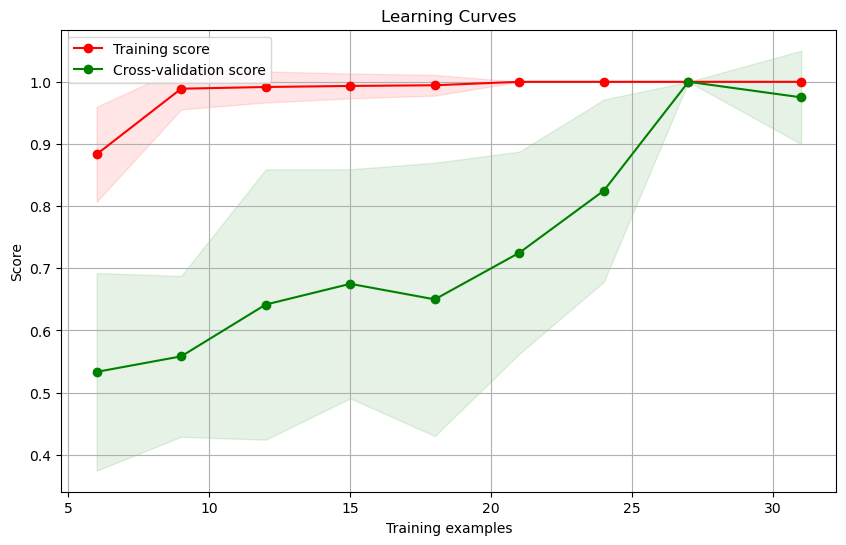

In [26]:
# compute the scores from cross-validation
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, cv=10, scoring='accuracy')

# print the mean and standard deviation of the scores
print("Accuracy: %0.2f" % scores.mean())



# determine the training sizes and the respective training and validation scores
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000),
    X_train,
    y_train,
    cv=10,
    scoring='accuracy',
    n_jobs=-1, # use all processors
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# compute mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# compute mean and standard deviation for validation set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()


Generate Data for LLM - Creates and designs novel space mission guidelines

In [27]:
# read CSV data from a file and store it as a string variable
csv_file_path = 'model data/model_data.csv'
with open(csv_file_path, 'r') as file:
    data = file.read()


# split the data into lines
lines = data.strip().split("\n")

# extract headers and rows
headers = [header.replace('"', '') for header in lines[0].split(",")]
rows = [line.split(",") for line in lines[1:]]

# separate data based on success and failure
success_data = [row for row in rows if row[-1] == "1"]
failure_data = [row for row in rows if row[-1] == "0"]

def extract_info(data, col_name):
    """Extract unique data from a given column."""
    idx = headers.index(col_name)
    return list(set(row[idx].replace('"', '') for row in data))

# things to focus on for success
successful_objectives = extract_info(success_data, "Objective")
successful_reasons = extract_info(success_data, "Reason")

# things to avoid or handle with care for failures
failed_objectives = extract_info(failure_data, "Objective")
failed_reasons = extract_info(failure_data, "Reason")

with open("../data/mission_design_guidelines.txt", "w") as file:
    file.write("Common mission objectives (based on past space missions):\n")
    for obj in successful_objectives:
        file.write(f"- {obj}\n")
    for reason in successful_reasons:
        file.write(f"- {reason}\n")

    file.write("\nThings to Avoid or Handle with Care (based on unsuccessful missions):\n")
    for obj in failed_objectives:
        file.write(f"- {obj}\n")
    for reason in failed_reasons:
        file.write(f"- {reason}\n")

print("Generated data for the language learning data has been saved to ../data/mission_design_guidelines.txt")


Generated data for the language learning data has been saved to ../data/mission_design_guidelines.txt


Save Model

In [28]:
# save the trained model to a file
model_filename = 'model.pkl'
joblib.dump(model, model_filename)

['model.pkl']